In [1]:
import torch # para Deep Learning
import torch.autograd as autograd # para autodiferenciação
import torch.nn as nn # para montar redes neurais
import torch.nn.functional as F # funções do Torch
import torch.optim as optim # para otimização com GDE
import numpy as np # para computação numérica
# carrega os dados MNIST
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets("tmp/", one_hot=False)
data = np.random.permutation(data.train.images) # só precisamos das imagens aqui

Extracting tmp/train-images-idx3-ubyte.gz
Extracting tmp/train-labels-idx1-ubyte.gz
Extracting tmp/t10k-images-idx3-ubyte.gz
Extracting tmp/t10k-labels-idx1-ubyte.gz


In [2]:
class RBM(nn.Module):
    def __init__(self, nv=28*28, nh=512, cd_steps=1):
        super(RBM, self).__init__()
        # inicializa os parâmetros da MBR
        self.W = nn.Parameter(torch.randn(nv, nh) * 0.01)
        self.bv = nn.Parameter(torch.zeros(nv))
        self.bh = nn.Parameter(torch.zeros(nh))
        self.cd_steps = cd_steps # define a forma de Contrastive Divergence

    def bernoulli(self, p):
        # return F.relu(torch.sign(p - autograd.Variable(torch.rand(p.size()).cuda())))     
        return F.relu(torch.sign(p - autograd.Variable(torch.rand(p.size()))))     
        
    def energy(self, v):
        b_term = v.mv(self.bv)
        linear_tranform = F.linear(v, self.W.t(), self.bh)
        h_term = linear_tranform.exp().add(1).log().sum(1)
        return (-h_term -b_term).mean()
    
    def sample_h(self, v):
        ph_given_v = torch.sigmoid(F.linear(v, self.W.t(), self.bh))
        return torch.bernoulli(ph_given_v) # self.bernoulli(ph_given_v)
    
    def sample_v(self, h):
        pv_given_h = torch.sigmoid(F.linear(h, self.W, self.bv))
        return torch.bernoulli(pv_given_h) # self.bernoulli(pv_given_h)
    
    def forward(self, v):
        vk = v.clone() # inicializa vk
        
        # realiza k passos de amostragem de Gibbs
        for step in range(self.cd_steps): 
            hk = self.sample_h(vk)
            vk = self.sample_v(hk)
        
        return v, vk.detach()

In [3]:
rbm = RBM()
# rbm.cuda()
optimizer = optim.Adam(rbm.parameters(), lr=0.001)

In [4]:
batch_size = 64 # tamanho do mini-lote
epochs = 25 # qtd de épocas de treinamento
for epoch in range(epochs):
    losses = []
    # loop de treinamento
    for i in range(0, len(data)-batch_size, batch_size):
        # cria os mini-lotes
        x_batch = data[i:i+batch_size]
        x_batch = torch.from_numpy(x_batch).float()
        # x_batch = x_batch.cuda()
        x_batch = autograd.Variable(x_batch).round()

        optimizer.zero_grad() # zera os gradientes computados anteriormente
        v, vk = rbm(x_batch) # realiza o forward-pass (CD com amostragens Gibbs)
        loss = rbm.energy(v) - rbm.energy(vk) # computa o custo
        losses.append(loss.data[0])

        loss.backward() # realiza o backward-pass
        optimizer.step() # atualiza os parâmetros
    
    print('Custo na época %d: ' % epoch, np.mean(losses))
    if epoch % 5 == 0 and epoch > 0: # a cada 5 épocas
        rbm.cd_steps += 2 # aumenta os as iterações em CD
        print('Alterando para CD%d...' % rbm.cd_steps)

Custo na época 0:  -14.9340023267
Custo na época 1:  -13.2965086114
Custo na época 2:  -12.0196942473
Custo na época 3:  -10.446302918
Custo na época 4:  -9.16346145648
Custo na época 5:  -8.11717368005
Alterando para CD3...
Custo na época 6:  -4.6632562533
Custo na época 7:  -5.68814598501
Custo na época 8:  -5.5872457058
Custo na época 9:  -5.41039126022
Custo na época 10:  -5.12717936008
Alterando para CD5...
Custo na época 11:  -3.47177980221
Custo na época 12:  -3.87929562445
Custo na época 13:  -3.87056603393
Custo na época 14:  -3.81260015024
Custo na época 15:  -3.72306953404
Alterando para CD7...
Custo na época 16:  -2.82202620945
Custo na época 17:  -3.07905114988
Custo na época 18:  -3.03119905447
Custo na época 19:  -2.99129414142
Custo na época 20:  -2.93090457938
Alterando para CD9...
Custo na época 21:  -2.40185347925
Custo na época 22:  -2.49198158628
Custo na época 23:  -2.47872242689
Custo na época 24:  -2.45057878949


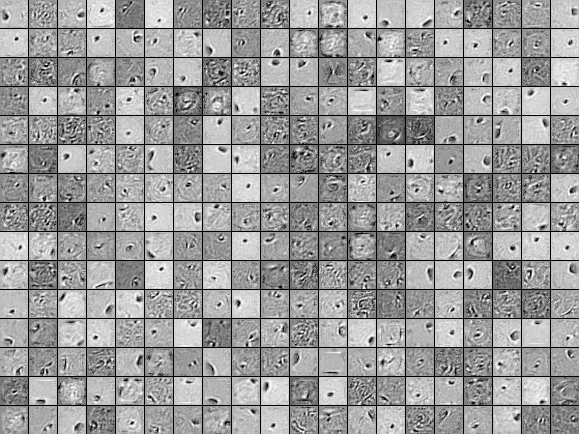

In [5]:
from dl_utils import tile_raster_images
import PIL

img = tile_raster_images(rbm.W.data.cpu().numpy().T,
                         img_shape=(28,28),
                         tile_shape=(15,20), tile_spacing=(1, 1))

im = PIL.Image.fromarray(img)
im.show()
im